# MOSE 3×5 Optimization

This notebook optimizes a three-variable MOSE design against five stakeholder objectives.

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate

from genetic_algorithm_pfm.genetic_algorithm_pfm.algorithm import GeneticAlgorithm

In [ ]:
# Stakeholder configuration (edit weights to match stakeholder input)
TOTAL_LENGTH = 1600.0

OBJECTIVE_KEYS = ['initial_cost', 'maintenance_cost', 'sight', 'accessibility', 'water_quality', 'overtopping_risk']

STAKEHOLDER_DATA = [
    {
        'name': 'Municipality',
        'weight': 0.5,
        'objective_weights': {
            'initial_cost': 0.40,
            'maintenance_cost': 0.25,
            'sight': 0.05,
            'accessibility': 0.10,
            'water_quality': 0.10,
            'overtopping_risk': 0.10,
        },
    },
    {
        'name': 'Residents',
        'weight': 0.2,
        'objective_weights': {
            'initial_cost': 0.10,
            'maintenance_cost': 0.10,
            'sight': 0.25,
            'accessibility': 0.20,
            'water_quality': 0.25,
            'overtopping_risk': 0.10,
        },
    },
    {
        'name': 'Environmental agency',
        'weight': 0.1,
        'objective_weights': {
            'initial_cost': 0.05,
            'maintenance_cost': 0.05,
            'sight': 0.10,
            'accessibility': 0.10,
            'water_quality': 0.55,
            'overtopping_risk': 0.15,
        },
    },
    {
        'name': 'Shippig companies',
        'weight': 0.15,
        'objective_weights': {
            'initial_cost': 0.10,
            'maintenance_cost': 0.10,
            'sight': 0.30,
            'accessibility': 0.20,
            'water_quality': 0.20,
            'overtopping_risk': 0.10,
        },
    },
]


def _normalize(values):
    values = np.asarray(values, dtype=float)
    total = values.sum()
    if total <= 0:
        raise ValueError('Weights must sum to a positive value.')
    return values / total


STAKEHOLDER_NAMES = [item['name'] for item in STAKEHOLDER_DATA]
STAKEHOLDER_WEIGHTS = _normalize([item['weight'] for item in STAKEHOLDER_DATA])
STAKEHOLDER_OBJECTIVE_WEIGHTS = np.vstack([
    _normalize([item['objective_weights'].get(key, 0.0) for key in OBJECTIVE_KEYS])
    for item in STAKEHOLDER_DATA
])

# Preference knot points (edit to match stakeholder data)
initial_cost_knots = [5.0e8, 1.0e9, 2.0e9, 3.5e9, 8.0e9]
initial_cost_pref = [100, 95, 90, 30, 0]

maintenance_cost_knots = [1.0e10, 10.0e11, 1.5e12]
maintenance_cost_pref = [100, 40, 0]

sight_knots = [0, 5, 10]
sight_pref = [0, 50, 100]

access_knots = [0, 5, 10]
access_pref = [0, 50, 100]

water_knots = [0, 5, 10]
water_pref = [0, 50, 100]

overtopping_knots = [0.0, 0.15, 0.30, 0.45, 0.60]
overtopping_pref = [100, 85, 60, 25, 0]

# Design variable bounds: x1 (m), x2 (-), x3 (-) — adjust if needed
bounds = [
    [0.0, TOTAL_LENGTH],  # x1
    [1.0, 10.0],          # x2
    [0.5, 5.0],           # x3
]

# Optional constraints placeholder: add callables if domain limits are required
constraints = []


In [42]:
MIN_CLOSING_TIME = 1e-3


def compute_initial_cost(x1, x2, x3):
    x1 = np.asarray(x1, dtype=float)
    x2 = np.asarray(x2, dtype=float)
    x3 = np.asarray(x3, dtype=float)

    movable_cost_per_meter = (
        5.2e5
        + 4.8e4 * np.power(x2, 1.5)
        + 2.2e5 / np.maximum(x3, MIN_CLOSING_TIME)
    )
    permanent_cost_per_meter = (
        1.8e4
        + 5.5e3 * np.power(x2, 1.1)
    )
    return x1 * movable_cost_per_meter + (TOTAL_LENGTH - x1) * permanent_cost_per_meter


def compute_maintenance_cost(x1, x2, x3):
    x1 = np.asarray(x1, dtype=float)
    x2 = np.asarray(x2, dtype=float)
    x3 = np.asarray(x3, dtype=float)

    movable_per_meter = (
        1.25e6
        + 4.8e5 * x2
        + 1.5e6 / np.power(np.maximum(x3, MIN_CLOSING_TIME), 1.2)
    )
    fixed_per_meter = (
        8.5e4
        + 2.2e4 * x2
    )

    movable_cost = movable_per_meter * x1 * 180.0
    fixed_cost = fixed_per_meter * (TOTAL_LENGTH - x1) * 55.0
    return movable_cost + fixed_cost


def compute_sight(x1, x2, x3):
    x1 = np.asarray(x1, dtype=float)
    x2 = np.asarray(x2, dtype=float)

    movable_view = (x1 / TOTAL_LENGTH) * 10.0
    fixed_view = ((TOTAL_LENGTH - x1) / TOTAL_LENGTH) * 10.0 / np.maximum(x2, 1e-6)
    raw = movable_view + fixed_view
    return np.clip(raw, sight_knots[0], sight_knots[-1])


def compute_accessibility(x1, x2, x3):
    x1 = np.asarray(x1, dtype=float)
    x3 = np.asarray(x3, dtype=float)
    raw = (x1 / TOTAL_LENGTH) * 10.0 - (10.0 / 7.0) * x3
    return np.clip(raw, access_knots[0], access_knots[-1])


def compute_water_quality(x1, x2, x3):
    x1 = np.asarray(x1, dtype=float)
    x3 = np.asarray(x3, dtype=float)
    raw = (x1 / TOTAL_LENGTH) * 10.0 - (10.0 / 24.0) * x3
    return np.clip(raw, water_knots[0], water_knots[-1])


def compute_overtopping_risk(x1, x2, x3):
    x2 = np.asarray(x2, dtype=float)
    # Exponential decay model: higher gates reduce annual overtopping risk
    raw = 0.65 * np.exp(-0.35 * (x2 - 1.0))
    return np.clip(raw, overtopping_knots[0], overtopping_knots[-1])


def preference_initial_cost(x1, x2, x3):
    costs = compute_initial_cost(x1, x2, x3)
    costs = np.clip(costs, initial_cost_knots[0], initial_cost_knots[-1])
    return pchip_interpolate(initial_cost_knots, initial_cost_pref, costs)


def preference_maintenance_cost(x1, x2, x3):
    costs = compute_maintenance_cost(x1, x2, x3)
    costs = np.clip(costs, maintenance_cost_knots[0], maintenance_cost_knots[-1])
    return pchip_interpolate(maintenance_cost_knots, maintenance_cost_pref, costs)


def preference_sight(x1, x2, x3):
    scores = compute_sight(x1, x2, x3)
    return pchip_interpolate(sight_knots, sight_pref, scores)


def preference_accessibility(x1, x2, x3):
    scores = compute_accessibility(x1, x2, x3)
    return pchip_interpolate(access_knots, access_pref, scores)


def preference_water_quality(x1, x2, x3):
    scores = compute_water_quality(x1, x2, x3)
    return pchip_interpolate(water_knots, water_pref, scores)


def preference_overtopping_risk(x1, x2, x3):
    risk = compute_overtopping_risk(x1, x2, x3)
    return pchip_interpolate(overtopping_knots, overtopping_pref, risk)


def objective(values):
    x1 = values[:, 0]
    x2 = values[:, 1]
    x3 = values[:, 2]

    preferences = {
        'initial_cost': preference_initial_cost(x1, x2, x3),
        'maintenance_cost': preference_maintenance_cost(x1, x2, x3),
        'sight': preference_sight(x1, x2, x3),
        'accessibility': preference_accessibility(x1, x2, x3),
        'water_quality': preference_water_quality(x1, x2, x3),
        'overtopping_risk': preference_overtopping_risk(x1, x2, x3),
    }

    stacked_preferences = np.vstack([np.asarray(preferences[key], dtype=float) for key in OBJECTIVE_KEYS])
    stakeholder_scores = STAKEHOLDER_OBJECTIVE_WEIGHTS @ stacked_preferences
    return STAKEHOLDER_WEIGHTS.tolist(), stakeholder_scores.tolist()


Running GA with minmax
The type of aggregation is set to minmax
Generation   Best score   Mean             Max stall    Diversity    Number of non-feasible results
0            13.4024      16.2116          0            0.003        0           
1            13.3512      15.0277          0            0.074        0           
2            13.3263      14.5562          0            0.202        0           
3            13.318       14.1547          0            0.293        0           
4            13.3143      13.7             0            0.302        0           
5            13.3139      13.6565          0            0.302        0           
6            13.3138      13.7751          0            0.302        0           
7            13.3137      13.6885          0            0.309        0           
8            13.3137      13.6803          1            0.306        0           
9            13.3137      13.6171          2            0.313        0           
10           13.

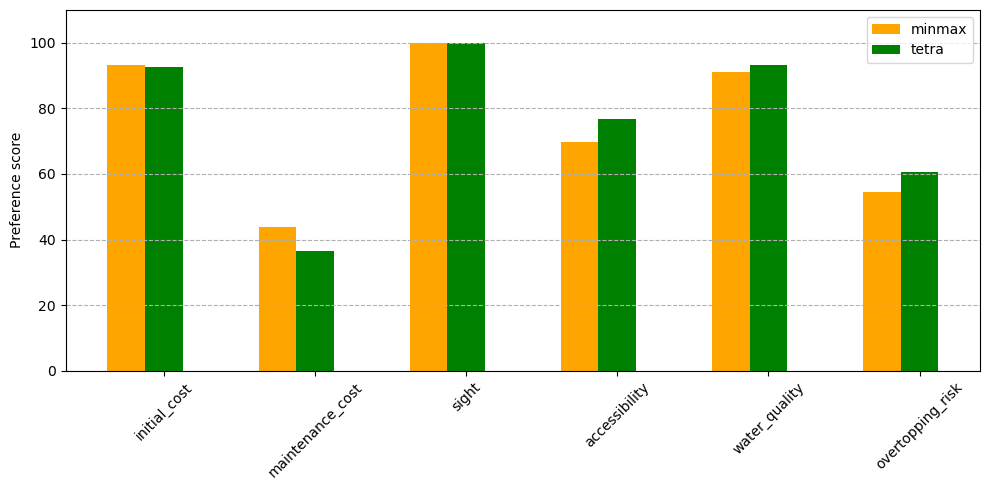

In [43]:
paradigms = ['minmax', 'tetra']
markers = ['o', '*', 's']
colours = ['orange', 'green', 'blue']

history = []

for idx, paradigm in enumerate(paradigms):
    options = {
        'n_bits': 10,
        'n_iter': 500,
        'n_pop': 600,
        'r_cross': 0.8,
        'max_stall': 10,
        'aggregation': paradigm,
        'var_type': 'real'
    }

    print(f'Running GA with {paradigm}')
    ga = GeneticAlgorithm(objective=objective, constraints=constraints, bounds=bounds, options=options)
    score, design_variables, _ = ga.run()

    x1_opt, x2_opt, x3_opt = design_variables

    metrics = {
        'initial_cost': compute_initial_cost(x1_opt, x2_opt, x3_opt),
        'maintenance_cost': compute_maintenance_cost(x1_opt, x2_opt, x3_opt),
        'sight': compute_sight(x1_opt, x2_opt, x3_opt),
        'accessibility': compute_accessibility(x1_opt, x2_opt, x3_opt),
        'water_quality': compute_water_quality(x1_opt, x2_opt, x3_opt),
        'overtopping_risk': compute_overtopping_risk(x1_opt, x2_opt, x3_opt),
    }

    preferences = {
        'initial_cost': float(preference_initial_cost(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
        'maintenance_cost': float(preference_maintenance_cost(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
        'sight': float(preference_sight(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
        'accessibility': float(preference_accessibility(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
        'water_quality': float(preference_water_quality(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
        'overtopping_risk': float(preference_overtopping_risk(np.array([x1_opt]), np.array([x2_opt]), np.array([x3_opt]))[0]),
    }

    _, stakeholder_pref_arrays = objective(np.array([[x1_opt, x2_opt, x3_opt]]))
    stakeholder_preferences = {
        name: float(stakeholder_pref_arrays[i][0])
        for i, name in enumerate(STAKEHOLDER_NAMES)
    }

    history.append({
        'paradigm': paradigm,
        'design': (x1_opt, x2_opt, x3_opt),
        'metrics': metrics,
        'preferences': preferences,
        'stakeholder_preferences': stakeholder_preferences,
    })

    print(f"Optimal design for {paradigm}:")
    print(f"  x1 = {x1_opt:.2f}")
    print(f"  x2 = {x2_opt:.2f}")
    print(f"  x3 = {x3_opt:.2f}")
    print('  Metrics:')
    for key, value in metrics.items():
        print(f"    {key}: {value:.3f}")
    print('  Preference scores:')
    for key, value in preferences.items():
        print(f"    {key}: {value:.2f}")
    print('  Stakeholder aggregates:')
    for name, value in stakeholder_preferences.items():
        print(f"    {name}: {value:.2f}")
    print('-' * 60)

# Optional: bar plot comparison of preference scores
labels = OBJECTIVE_KEYS if history else []
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))
for i, record in enumerate(history):
    scores = [record['preferences'][label] for label in labels]
    ax.bar(x + i * width, scores, width, label=record['paradigm'], color=colours[i % len(colours)])

ax.set_xticks(x + width)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel('Preference score')
ax.set_ylim(0, 110)
ax.legend()
ax.grid(linestyle='--', axis='y')
fig.tight_layout()
plt.show()


In [44]:
# Summary of optimal design variables and key metrics
if not history:
    raise RuntimeError('Run the GA cell first to populate history.')

print('Paradigm | x1 [m] | x2 [-] | x3 [-] | Initial cost | Maintenance cost | Sight | Accessibility | Water quality | Overtopping risk')
print('-' * 150)
for record in history:
    x1_opt, x2_opt, x3_opt = record['design']
    metrics = record['metrics']
    print(f"{record['paradigm']:>8} | {x1_opt:7.2f} | {x2_opt:6.2f} | {x3_opt:6.2f} | "
          f"{metrics['initial_cost']:12.3e} | {metrics['maintenance_cost']:14.3e} | "
          f"{metrics['sight']:5.2f} | {metrics['accessibility']:12.2f} | {metrics['water_quality']:13.2f} | "
          f"{metrics['overtopping_risk']:15.3f}")

print()
print('Stakeholder weights (normalized):')
for name, weight in zip(STAKEHOLDER_NAMES, STAKEHOLDER_WEIGHTS):
    print(f"  {name}: {weight:.3f}")

print()
print('Stakeholder aggregate preference scores:')
row_header = 'Paradigm'.ljust(12)
for name in STAKEHOLDER_NAMES:
    row_header += f"| {name:>18} "
print(row_header)
print('-' * len(row_header))
for record in history:
    row = f"{record['paradigm']:>12}"
    for name in STAKEHOLDER_NAMES:
        row += f"| {record['stakeholder_preferences'][name]:18.2f} "
    print(row)


Paradigm | x1 [m] | x2 [-] | x3 [-] | Initial cost | Maintenance cost | Sight | Accessibility | Water quality | Overtopping risk
------------------------------------------------------------------------------------------------------------------------------------------------------
  minmax | 1598.44 |   2.97 |   2.12 |    1.390e+09 |      9.451e+11 |  9.99 |         6.97 |          9.11 |           0.326
   tetra | 1598.44 |   3.23 |   1.62 |    1.495e+09 |      1.049e+12 |  9.99 |         7.68 |          9.32 |           0.298

Stakeholder weights (normalized):
  Municipality: 0.526
  Residents: 0.211
  Environmental agency: 0.105
  Tourism Business: 0.158

Stakeholder aggregate preference scores:
Paradigm    |       Municipality |          Residents | Environmental agency |   Tourism Business 
--------------------------------------------------------------------------------------------------
      minmax|              74.70 |              80.82 |              82.06 |              81.26 

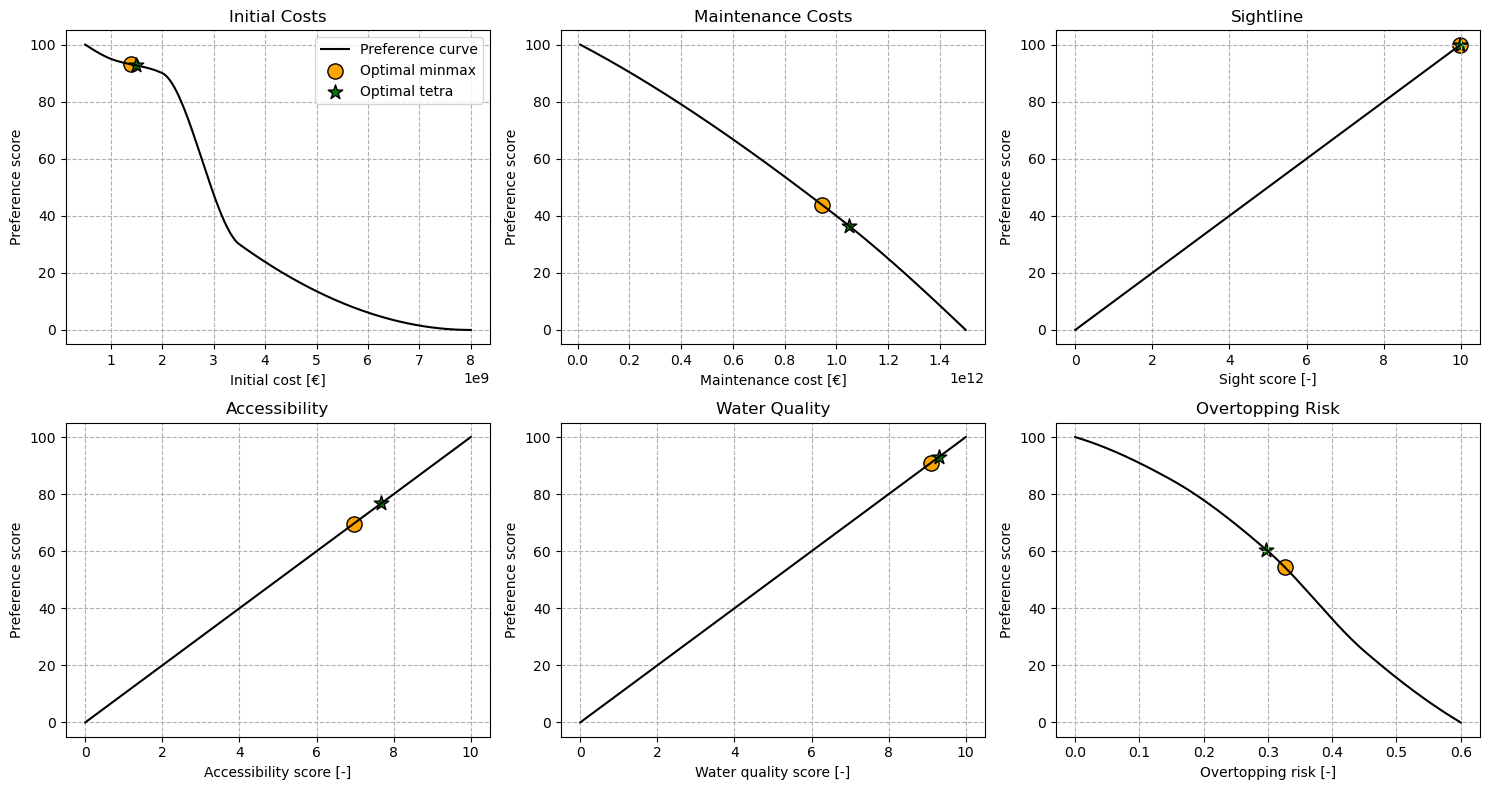

In [45]:
# Preference curves with GA solutions overlaid
if not history:
    raise RuntimeError('Run the GA cell first to populate history.')

objectives = [
    {
        'key': 'initial_cost',
        'title': 'Initial Costs',
        'knots_x': initial_cost_knots,
        'knots_y': initial_cost_pref,
        'compute': compute_initial_cost,
        'xlabel': 'Initial cost [€]'
    },
    {
        'key': 'maintenance_cost',
        'title': 'Maintenance Costs',
        'knots_x': maintenance_cost_knots,
        'knots_y': maintenance_cost_pref,
        'compute': compute_maintenance_cost,
        'xlabel': 'Maintenance cost [€]'
    },
    {
        'key': 'sight',
        'title': 'Sightline',
        'knots_x': sight_knots,
        'knots_y': sight_pref,
        'compute': compute_sight,
        'xlabel': 'Sight score [-]'
    },
    {
        'key': 'accessibility',
        'title': 'Accessibility',
        'knots_x': access_knots,
        'knots_y': access_pref,
        'compute': compute_accessibility,
        'xlabel': 'Accessibility score [-]'
    },
    {
        'key': 'water_quality',
        'title': 'Water Quality',
        'knots_x': water_knots,
        'knots_y': water_pref,
        'compute': compute_water_quality,
        'xlabel': 'Water quality score [-]'
    },
    {
        'key': 'overtopping_risk',
        'title': 'Overtopping Risk',
        'knots_x': overtopping_knots,
        'knots_y': overtopping_pref,
        'compute': compute_overtopping_risk,
        'xlabel': 'Overtopping risk [-]'
    },
]

n_cols = 3
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.flatten()

for idx_obj, obj in enumerate(objectives):
    ax = axes[idx_obj]
    knots_x = np.array(obj['knots_x'], dtype=float)
    knots_y = np.array(obj['knots_y'], dtype=float)

    # gather GA results for this objective
    samples = [knots_x.min(), knots_x.max()]
    for record in history:
        x1_opt, x2_opt, x3_opt = record['design']
        samples.append(obj['compute'](x1_opt, x2_opt, x3_opt))

    x_min = min(samples)
    x_max = max(samples)
    if np.isclose(x_min, x_max):
        x_max = x_min + 1.0

    x_range = np.linspace(x_min, x_max, 300)

    # Clip into knot domain to avoid extrapolation beyond preference definition
    x_range_clipped = np.clip(x_range, knots_x.min(), knots_x.max())
    pref_curve = pchip_interpolate(knots_x, knots_y, x_range_clipped)

    ax.plot(x_range, pref_curve, color='black', label='Preference curve')

    for i, record in enumerate(history):
        x1_opt, x2_opt, x3_opt = record['design']
        metric_value = obj['compute'](x1_opt, x2_opt, x3_opt)
        pref_value = record['preferences'][obj['key']]
        ax.scatter(metric_value, pref_value, color=colours[i % len(colours)],
                   marker=markers[i % len(markers)], s=120, edgecolor='black',
                   label=f"Optimal {record['paradigm']}")

    ax.set_title(obj['title'])
    ax.set_xlabel(obj['xlabel'])
    ax.set_ylabel('Preference score')
    ax.set_ylim(-5, 105)
    ax.grid(linestyle='--')

    if idx_obj == 0:
        ax.legend()

# Hide the unused subplot if objectives < rows*cols
for j in range(len(objectives), len(axes)):
    axes[j].axis('off')

fig.tight_layout()
plt.show()
